### Part 1. Running model with minimal features

In [1]:
from src.models_service.models_service import SklearnDataPreparation as DP
from sklearn.ensemble import RandomForestClassifier



from src.common.logs import setup_logging

import logging
logger = setup_logging(logger_name=__name__,
                        console_level=logging.ERROR, 
                        log_file_level=logging.INFO)

config = {
    'AV': {
        'key': '',
        'ticker': 'VGT',
        'outputsize': 'full',
        'key_adjusted_close': 'Adj Close',
        'key_volume': 'Volume',
    },
    'data': {
        'test_size': 0.05,
    }, 
    'model': {
        'name': 'RF', 
    },
    'plots': {
        'show': True,
    },
}

2023-10-25 22:59:52.236214: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 22:59:52.236282: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 22:59:52.236311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 22:59:52.243734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
_, _, _, _, df = DP(config=config).data_prep(logger=logger)
df['Target'] = (df['Tomorrow'] > df['Adj Close']).astype(int)

from sklearn.model_selection import train_test_split

X = df.drop(['Tomorrow', 'Target'], axis=1)
y = df['Target']
df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(X, y, test_size=config['data']['test_size'], shuffle=False)
df_train_X.columns

Index(['Open', 'Adj Close', 'Volume', 'high-low variance'], dtype='object')

In [21]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=0)
model.fit(df_train_X, df_train_y)

RandomForestClassifier(min_samples_split=100, random_state=0)

In [32]:
from sklearn.metrics import precision_score 
import pandas as pd

preds = pd.Series(model.predict(df_test_X), index = df_test_y.index)

In [24]:
precision_score(df_test_y, preds)

0.55

<Axes: xlabel='Date'>

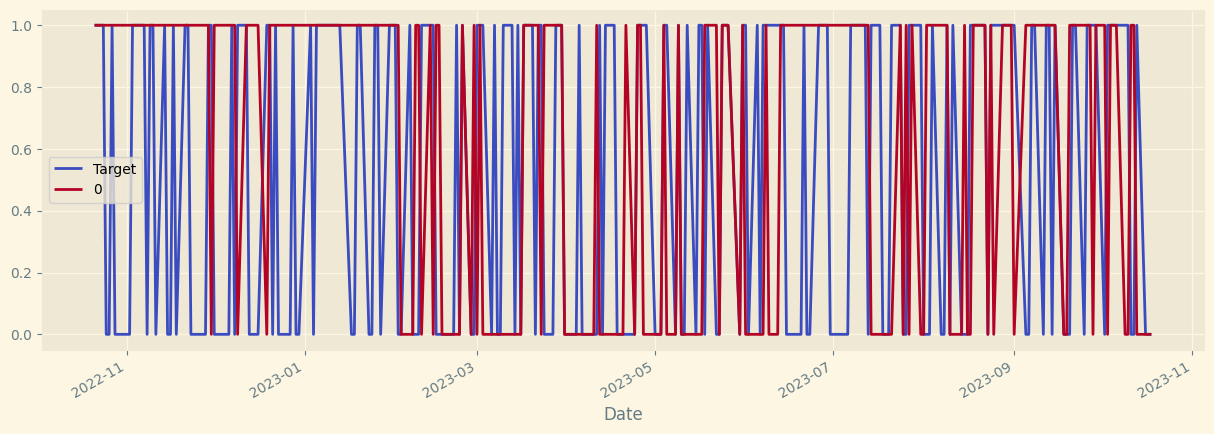

In [31]:
combined = pd.concat([df_test_y, preds], axis=1)
combined.plot(colormap='coolwarm')

### Part 2. Adding more features and Backtesting

In [49]:
def predict(train, test, predictors, target, model):
    model.fit(train[predictors], train[target].values.ravel())
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

In [50]:
def backtest(data, model, predictors, target, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, target, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [52]:
predictions = backtest(df, model, predictors=df.drop(columns=['Tomorrow','Target']).columns, target='Target')
predictions["Predictions"].value_counts()

Predictions
1    1375
0    1089
Name: count, dtype: int64

In [53]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5650909090909091

In [54]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.562094
0    0.437906
Name: count, dtype: float64

In [58]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Adj Close"] / rolling_averages["Adj Close"]
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [60]:
df = df.dropna(subset=df.columns[df.columns != "Tomorrow"])
df.head(2)

,Open,Adj Close,Volume,high-low variance,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,
2008-01-22,53.13,43.597421,156000,7.058159,43.571755,0,0.987501,0.0,0.968711,0.0,0.861476,26.0,0.892739,137.0,1.041705,538.0
2008-01-23,49.24,43.571755,190000,5.544273,45.068920,1,0.999706,0.0,0.980592,0.0,0.863546,26.0,0.892316,137.0,1.041032,537.0


In [61]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [67]:
def predict(train, test, predictors, target, model):
    model.fit(train[predictors], train[target])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

predictions = backtest(df, model, new_predictors, target="Target")

In [68]:
predictions["Predictions"].value_counts()

Predictions
0.0    1396
1.0      68
Name: count, dtype: int64

In [69]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5441176470588235

In [70]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.553279
0    0.446721
Name: count, dtype: float64